In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import warnings
import tensorflow as tf
import seaborn as sns
import sklearn
import random
import math
import time
import os
import pywt  # Bibliothèque pour les ondelettes

from scipy.stats import kurtosis, skew
from numpy.fft import fft


from lime.lime_tabular import RecurrentTabularExplainer
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import GroupKFold
from sklearn import preprocessing
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, GRU
from scipy import optimize
from tensorflow.keras import optimizers


from sp_modif.model_function import *
from sp_modif.methods import *
from sp_modif.data_prep import *
from sp_modif.evaluator import *
from sp_modif.SHAP import *
from sp_modif.L2X import *
from methods import *

%matplotlib inline
warnings.filterwarnings('ignore')

SEED = 0
def set_seed(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

# Appeler la fonction pour fixer le seed
set_seed(SEED)

In [22]:
DEFAULT_SAMPLING_RATE = 25600
def extract_temporal_features(signal):
    """Extrait les caractéristiques temporelles d'un signal."""
    rms = np.sqrt(np.mean(signal**2))
    mean_abs = np.mean(np.abs(signal))
    max_abs = np.max(np.abs(signal))
    energy = np.sum(signal**2)
    
    features = {
        'mean': signal.mean(),
        'std': signal.std(),
        'peak_to_peak': signal.max() - signal.min(),
        'rms': rms,
        'mean_abs': mean_abs,
        'max_abs': max_abs,
        'skewness': skew(signal),
        'kurtosis': kurtosis(signal),
        'form_factor': rms / mean_abs if mean_abs != 0 else 0,
        'crest_factor': signal.max() / rms if rms != 0 else 0,
        'impulse_factor': signal.max() / mean_abs if mean_abs != 0 else 0,
        'margin_factor': signal.max() / (np.mean(np.sqrt(np.abs(signal))) ** 2) if np.mean(np.sqrt(np.abs(signal))) != 0 else 0,
        'energy': energy
    }
    
    # Moments centrés (ordre 5 à 11)
    for order in range(5, 12):
        features[f'moment_{order}'] = np.mean((signal - signal.mean())**order)
    
    return features

def extract_frequency_features(signal, sampling_rate=25600):
    """Extrait les caractéristiques fréquentielles d'un signal donné."""
    signal = np.asarray(signal)
    if signal.size == 0:
        raise ValueError("Signal vide : impossible de calculer des caractéristiques fréquentielles.")

    # FFT
    N = len(signal)
    freqs = fft(signal)
    freqs = np.abs(freqs[:N // 2])  # Composantes positives
    freq_bins = np.fft.fftfreq(N, d=1/sampling_rate)[:N // 2]

    # Normalisation pour l'entropie spectrale
    power_spectrum = freqs**2
    power_spectrum /= np.sum(power_spectrum)

    # Calcul des caractéristiques
    max_amplitude = np.max(freqs)
    mean_freq = np.mean(freqs)
    rms_freq = np.sqrt(np.mean(freqs**2))
    variance_freq = np.var(freqs)
    std_freq = np.std(freqs)
    kurtosis_freq = kurtosis(freqs)
    skewness_freq = skew(freqs)
    peak_freq = freq_bins[np.argmax(freqs)]
    form_factor_freq = rms_freq / mean_freq if mean_freq != 0 else 0
    crest_factor_freq = max_amplitude / rms_freq if rms_freq != 0 else 0
    spectral_entropy = -np.sum(power_spectrum * np.log2(power_spectrum + 1e-10))
    
    # Division en bandes de fréquence
    num_bands = 25
    band_width = (sampling_rate / 2) / num_bands
    energy_bands = {}
    for band in range(num_bands):
        low = band * band_width
        high = (band + 1) * band_width
        energy_bands[f'energy_band_{band}'] = np.sum(power_spectrum[(freq_bins >= low) & (freq_bins < high)])
    
    features = {
        'max_amplitude': max_amplitude,
        'mean_freq': mean_freq,
        'rms_freq': rms_freq,
        'variance_freq': variance_freq,
        'std_freq': std_freq,
        'kurtosis_freq': kurtosis_freq,
        'skewness_freq': skewness_freq,
        'peak_freq': peak_freq,
        'form_factor_freq': form_factor_freq,
        'crest_factor_freq': crest_factor_freq,
        'spectral_entropy': spectral_entropy
    }
    features.update(energy_bands)
    return features

def extract_derivative_features(signal):
    """Extrait les caractéristiques temporelles de la dérivée du signal."""
    derivative = np.diff(signal, prepend=signal[0])
    return extract_temporal_features(derivative)

def extract_integral_features(signal):
    """Extrait les caractéristiques temporelles de l'intégrale du signal."""
    integral = np.cumsum(signal)
    return extract_temporal_features(integral)

def extract_imf_features(signal, num_imfs=5):
    """Extrait les caractéristiques des IMFs à partir d'une décomposition en ondelettes."""
    coeffs = pywt.wavedec(signal, wavelet='db4', level=num_imfs)
    features = {}
    for i, coeff in enumerate(coeffs[:num_imfs]):
        features[f'imf_rms_{i}'] = np.sqrt(np.mean(coeff**2))
        features[f'imf_energy_{i}'] = np.sum(coeff**2)
        features[f'imf_entropy_{i}'] = -np.sum((coeff**2 / np.sum(coeff**2)) * np.log2(coeff**2 / np.sum(coeff**2) + 1e-10))
    return features

def extract_features(signal, sampling_rate=25600):
    """Extrait toutes les caractéristiques temporelles, fréquentielles, dérivées et intégrées."""
    temporal_features = extract_temporal_features(signal)
    frequency_features = extract_frequency_features(signal, sampling_rate)
    derivative_features = extract_derivative_features(signal)
    integral_features = extract_integral_features(signal)
    imf_features = extract_imf_features(signal)

    # Fusionner toutes les caractéristiques dans un seul dictionnaire
    all_features = {
        **temporal_features,
        **frequency_features,
        **{f'derivative_{k}': v for k, v in derivative_features.items()},
        **{f'integral_{k}': v for k, v in integral_features.items()},
        **imf_features
    }
    return all_features

def extract_time_frequency_features(signal, wavelet='db4', level=3):
    """Extrait les caractéristiques temps-fréquence à partir d'une décomposition en ondelettes."""
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = {}
    for i, coeff in enumerate(coeffs):
        features[f'wavelet_energy_level_{i}'] = np.sum(coeff**2)
    return features
################ Extract all features 

def extract_features_per_window(data, sampling_rate=DEFAULT_SAMPLING_RATE):
    """Extrait les caractéristiques de chaque fenêtre de données."""
    features_list = []

    for bearing_id, group in data.groupby('bearing_id'):
        print(f"Processing bearing: {bearing_id}, Data size: {len(group)}")
        horizontal_signal = group['Horizontal_Accel'].values
        vertical_signal = group['Vertical_Accel'].values
        RUL = group['time_seconds'].max()
        
        if True :
            # Extraction des caractéristiques temporelles, fréquentielles et temps-fréquence
            temporal_features_h = extract_temporal_features(horizontal_signal)
            temporal_features_v = extract_temporal_features(vertical_signal)
            frequency_features_h = extract_frequency_features(horizontal_signal, sampling_rate)
            frequency_features_v = extract_frequency_features(vertical_signal, sampling_rate)
            time_frequency_features_h = extract_imf_features(horizontal_signal)  # IMFs pour horizontal
            time_frequency_features_v = extract_imf_features(vertical_signal)  # IMFs pour vertical
            
            # Extraction des caractéristiques pour la dérivée et l'intégrale
            derivative_features_h = extract_derivative_features(horizontal_signal)
            derivative_features_v = extract_derivative_features(vertical_signal)
            integral_features_h = extract_integral_features(horizontal_signal)
            integral_features_v = extract_integral_features(vertical_signal)
            
            # Fusionner toutes les caractéristiques
            features = {f"{k}_h": v for k, v in temporal_features_h.items()}
            features.update({f"{k}_v": v for k, v in temporal_features_v.items()})
            features.update({f"{k}_freq_h": v for k, v in frequency_features_h.items()})
            features.update({f"{k}_freq_v": v for k, v in frequency_features_v.items()})
            features.update({f"{k}_tf_h": v for k, v in time_frequency_features_h.items()})
            features.update({f"{k}_tf_v": v for k, v in time_frequency_features_v.items()})
            features.update({f"derivative_{k}_h": v for k, v in derivative_features_h.items()})
            features.update({f"derivative_{k}_v": v for k, v in derivative_features_v.items()})
            features.update({f"integral_{k}_h": v for k, v in integral_features_h.items()})
            features.update({f"integral_{k}_v": v for k, v in integral_features_v.items()})
            
            # Calculer le RUL
            features['RUL'] = RUL  # Ajout de RUL normalisé
            
            # Ajouter les caractéristiques extraites à la liste
            features_list.append(features)

    return pd.DataFrame(features_list)

################ Data loading

def load_vibration_data(data_folder, idx=None):
    """Charge les fichiers de vibration et calcule le temps en secondes pour chaque échantillon."""
    vibration_files = [f for f in os.listdir(data_folder) if f.startswith('acc_') and f.endswith('.csv')]
    if not vibration_files:
        print("No vibration files found in the specified folder.")
        return pd.DataFrame()  # Retourne un DataFrame vide si aucun fichier n'est trouvé
    
    vibration_data = []

    for file in vibration_files:
        file_path = os.path.join(data_folder, file)
        df = pd.read_csv(file_path, names=['Hour', 'Minute', 'Second', 'Microsecond', 'Horizontal_Accel', 'Vertical_Accel'])
        
        # Extraction de l'identifiant du roulement
        bearing_id = file.split('_')[1].split('.')[0]
        df['bearing_id'] = idx + bearing_id
        
        # Calcul du temps en secondes pour chaque échantillon
        df['time_seconds'] = df['Hour'] * 3600 + df['Minute'] * 60 + df['Second'] + df['Microsecond'] * 1e-6
        vibration_data.append(df)

    # Concaténation de toutes les données de vibration en un DataFrame unique
    result = pd.concat(vibration_data, ignore_index=True)
    print(f"Loaded data shape: {result.shape}")
    print(result.head())
    return result

In [229]:
list_idx_train = ['1_1', '1_2', '2_1', '2_2']
folder = 'PRONOSTIA/Learning_set/'

In [230]:
idx = list_idx_train[0]
bearing = 'Bearing' + idx

base_dir = os.path.join(folder, bearing)
data_folder = base_dir
df_1_1 = load_vibration_data(data_folder=data_folder, idx=idx)

Loaded data shape: (7175680, 8)
   Hour  Minute  Second  Microsecond  Horizontal_Accel  Vertical_Accel  \
0     9      39      39      65664.0             0.552          -0.146   
1     9      39      39      65703.0             0.501          -0.480   
2     9      39      39      65742.0             0.138           0.435   
3     9      39      39      65781.0            -0.423           0.240   
4     9      39      39      65820.0            -0.802           0.020   

  bearing_id  time_seconds  
0   1_100001  34779.065664  
1   1_100001  34779.065703  
2   1_100001  34779.065742  
3   1_100001  34779.065781  
4   1_100001  34779.065820  


In [231]:
idx = list_idx_train[1]
bearing = 'Bearing' + idx

base_dir = os.path.join(folder, bearing)
data_folder = base_dir
df_1_2 = load_vibration_data(data_folder=data_folder, idx=idx)

Loaded data shape: (2229760, 8)
   Hour  Minute  Second  Microsecond  Horizontal_Accel  Vertical_Accel  \
0     8      47       5     196910.0             0.050          -0.253   
1     8      47       5     196950.0             0.165          -0.140   
2     8      47       5     196990.0             0.125           0.542   
3     8      47       5     197030.0             0.157          -0.261   
4     8      47       5     197070.0             0.421           0.081   

  bearing_id  time_seconds  
0   1_200001   31625.19691  
1   1_200001   31625.19695  
2   1_200001   31625.19699  
3   1_200001   31625.19703  
4   1_200001   31625.19707  


In [232]:
# Utilisation de la fonction principale
list_idx_test = ['1_3', '1_4', '2_3', '2_4']
idx = list_idx_test[1]
folder = 'PRONOSTIA/Test_set/'
bearing = 'Bearing' + idx

base_dir = os.path.join(folder, bearing)
data_folder = base_dir
df_1_3 = load_vibration_data(data_folder=data_folder, idx=idx)

Loaded data shape: (2915840, 8)
   Hour  Minute  Second  Microsecond  Horizontal_Accel  Vertical_Accel  \
0     8       8       0     425040.0             0.065          -0.058   
1     8       8       0     425080.0             0.438           0.179   
2     8       8       0     425120.0            -0.079           0.646   
3     8       8       0     425160.0            -0.523          -0.411   
4     8       8       0     425200.0            -0.146          -0.387   

  bearing_id  time_seconds  
0   1_400001   29280.42504  
1   1_400001   29280.42508  
2   1_400001   29280.42512  
3   1_400001   29280.42516  
4   1_400001   29280.42520  


#### Extraction des features

In [233]:
df_features_extracted_1_1 = extract_features_per_window(df_1_1)
df_features_extracted_1_1.loc[2120:2121, 'RUL'] = [55979.16562, 55989.16562]
df_features_extracted_1_2 = extract_features_per_window(df_1_2)
df_features_extracted_1_3 = extract_features_per_window(df_1_3)

Processing bearing: 1_100001, Data size: 2560
Processing bearing: 1_100002, Data size: 2560
Processing bearing: 1_100003, Data size: 2560
Processing bearing: 1_100004, Data size: 2560
Processing bearing: 1_100005, Data size: 2560
Processing bearing: 1_100006, Data size: 2560
Processing bearing: 1_100007, Data size: 2560
Processing bearing: 1_100008, Data size: 2560
Processing bearing: 1_100009, Data size: 2560
Processing bearing: 1_100010, Data size: 2560
Processing bearing: 1_100011, Data size: 2560
Processing bearing: 1_100012, Data size: 2560
Processing bearing: 1_100013, Data size: 2560
Processing bearing: 1_100014, Data size: 2560
Processing bearing: 1_100015, Data size: 2560
Processing bearing: 1_100016, Data size: 2560
Processing bearing: 1_100017, Data size: 2560
Processing bearing: 1_100018, Data size: 2560
Processing bearing: 1_100019, Data size: 2560
Processing bearing: 1_100020, Data size: 2560
Processing bearing: 1_100021, Data size: 2560
Processing bearing: 1_100022, Data

In [234]:
rul_max = df_features_extracted_1_1.RUL.max()
df_features_extracted_1_1.loc[:, 'RUL'] =(rul_max -df_features_extracted_1_1['RUL'])
df_features_extracted_1_1['RUL'] = df_features_extracted_1_1['RUL']/df_features_extracted_1_1.RUL.max()

In [235]:
df_features_extracted_1_1

,mean_h,std_h,peak_to_peak_h,rms_h,mean_abs_h,max_abs_h,skewness_h,kurtosis_h,form_factor_h,crest_factor_h,...,integral_margin_factor_v,integral_energy_v,integral_moment_5_v,integral_moment_6_v,integral_moment_7_v,integral_moment_8_v,integral_moment_9_v,integral_moment_10_v,integral_moment_11_v,RUL
0,0.003465,0.561735,3.773,0.561746,0.450874,2.010,-0.004711,-0.131465,1.245904,3.578132,...,3.437915,1.215776e+04,3.742202e+00,9.169275e+02,-4.406474e+02,1.943821e+04,-2.292746e+04,4.710928e+05,-8.834347e+05,1.000000
1,0.005609,0.535083,3.640,0.535112,0.428814,1.915,-0.025791,-0.084646,1.247889,3.223621,...,3.427483,1.007166e+04,6.321226e+01,4.766194e+02,1.405670e+03,8.577366e+03,3.225453e+04,1.789273e+05,7.711803e+05,0.999643
2,0.004196,0.531142,3.677,0.531158,0.421677,1.901,-0.005016,0.033388,1.259633,3.343636,...,1.179341,2.316493e+04,-6.473747e-02,4.218417e+02,6.107979e+01,7.042703e+03,2.148107e+03,1.294069e+05,5.947041e+04,0.999286
3,-0.001824,0.554830,3.788,0.554833,0.439284,1.910,-0.080165,0.043419,1.263041,3.384801,...,1.838585,7.362324e+03,-2.315089e+00,3.157940e+01,-2.516376e+01,2.360354e+02,-2.761492e+02,2.066175e+03,-3.164510e+03,0.998929
4,-0.002582,0.566646,3.427,0.566652,0.453978,1.767,-0.034187,-0.185477,1.248193,3.118317,...,2.262906,4.962433e+05,2.517151e+03,2.474684e+05,4.095941e+05,2.478271e+07,6.484293e+07,2.750422e+09,1.035113e+10,0.998572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2798,-0.090720,6.706946,92.443,6.707559,3.937015,48.148,-0.517714,12.168831,1.703717,6.603743,...,0.217508,2.699987e+07,1.442518e+08,8.168540e+10,1.236641e+12,5.650977e+14,1.002133e+16,4.282351e+18,7.697065e+19,0.001428
2799,-0.035204,4.856815,61.837,4.856943,3.109243,31.173,0.037260,9.357848,1.562098,6.418235,...,1.335829,4.635232e+06,1.600420e+07,1.681869e+09,7.481678e+10,6.024685e+12,3.676406e+14,2.746642e+16,1.887350e+18,0.001071
2800,0.030579,5.130236,68.810,5.130328,3.430638,38.767,-0.271548,7.052713,1.495444,5.855961,...,8.529090,2.214133e+05,4.809186e+04,4.164075e+07,-3.579219e+08,7.277247e+10,-1.413496e+12,1.467638e+14,-4.123212e+15,0.000714
2801,0.023402,6.297281,83.598,6.297325,3.703332,43.604,-0.351591,10.912484,1.700448,6.350951,...,1.308356,2.308869e+06,-7.575399e+06,8.204542e+08,-5.382929e+10,5.191221e+12,-4.339324e+14,4.058119e+16,-3.651464e+18,0.000357


In [236]:
rul_max = df_features_extracted_1_2.RUL.max()
df_features_extracted_1_2.loc[:, 'RUL'] =(-df_features_extracted_1_2['RUL'] + rul_max)
df_features_extracted_1_2['RUL'] = df_features_extracted_1_2['RUL']/df_features_extracted_1_2.RUL.max()

In [237]:
df_features_extracted_1_2

,mean_h,std_h,peak_to_peak_h,rms_h,mean_abs_h,max_abs_h,skewness_h,kurtosis_h,form_factor_h,crest_factor_h,...,integral_margin_factor_v,integral_energy_v,integral_moment_5_v,integral_moment_6_v,integral_moment_7_v,integral_moment_8_v,integral_moment_9_v,integral_moment_10_v,integral_moment_11_v,RUL
0,-0.000191,0.538710,4.097,0.538710,0.422611,2.330,-0.276680,0.406356,1.274718,3.280058,...,0.258266,1.964586e+05,1296.995393,2.827640e+04,1.030196e+05,1.577870e+06,7.556080e+06,9.664948e+07,5.487413e+08,1.000000
1,0.003091,0.505568,3.797,0.505577,0.402071,1.982,-0.081477,0.194197,1.257432,3.920272,...,0.351427,1.467106e+05,-746.008756,2.108330e+04,-4.747015e+04,1.042169e+06,-3.202619e+06,5.750164e+07,-2.227836e+08,0.998851
2,-0.007987,0.542382,3.598,0.542441,0.429913,1.830,0.091936,0.034492,1.261747,3.373639,...,3.020876,7.289397e+04,-329.490294,1.189182e+04,-1.762748e+04,5.368328e+05,-9.767681e+05,2.634871e+07,-5.595462e+07,0.997701
3,0.022698,0.514507,3.486,0.515008,0.408112,1.886,-0.020360,0.087339,1.261929,3.106749,...,0.498915,3.425787e+05,-18584.367700,6.391577e+05,-3.880464e+06,9.548293e+07,-7.657037e+08,1.554069e+10,-1.485360e+11,0.996552
4,0.002741,0.485594,3.241,0.485601,0.386860,1.705,0.014206,-0.042692,1.255238,3.163088,...,3.285689,8.821621e+04,-174.437271,2.456234e+04,-5.431345e+03,1.443748e+06,2.593962e+04,9.325935e+07,3.271816e+07,0.995402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,-0.000738,1.639656,19.328,1.639656,1.199922,10.342,0.015849,3.071155,1.366469,5.480418,...,4.252582,1.740924e+05,-3481.776087,3.155340e+05,-2.075937e+06,7.866903e+07,-8.915891e+08,2.532321e+10,-3.642060e+11,0.004598
867,0.010361,1.646456,16.761,1.646489,1.209400,8.697,-0.041221,2.540758,1.361409,4.897696,...,0.527776,9.256094e+05,56787.073606,7.126536e+06,3.671107e+06,3.045658e+09,-1.688484e+10,1.734686e+12,-2.479386e+13,0.003448
868,0.005827,1.781084,22.062,1.781094,1.278976,11.240,0.064473,4.616347,1.392594,6.310728,...,4.449350,2.159260e+05,72766.109054,3.769399e+06,2.888984e+07,1.290803e+09,1.156843e+10,5.039946e+11,4.731973e+12,0.002299
869,-0.012270,2.135618,34.804,2.135654,1.428479,17.649,0.154663,11.877210,1.495054,8.263981,...,0.661157,2.568491e+06,257057.801584,9.960150e+07,4.461466e+08,1.025046e+11,3.795855e+11,1.420416e+14,-3.296567e+14,0.001149


In [238]:
rul_max = df_features_extracted_1_3.RUL.max()
df_features_extracted_1_3.loc[:, 'RUL'] =-df_features_extracted_1_3['RUL'] + rul_max
df_features_extracted_1_3['RUL'] = df_features_extracted_1_3['RUL']/df_features_extracted_1_3.RUL.max()

In [239]:
df_features_extracted_1_3

,mean_h,std_h,peak_to_peak_h,rms_h,mean_abs_h,max_abs_h,skewness_h,kurtosis_h,form_factor_h,crest_factor_h,...,integral_margin_factor_v,integral_energy_v,integral_moment_5_v,integral_moment_6_v,integral_moment_7_v,integral_moment_8_v,integral_moment_9_v,integral_moment_10_v,integral_moment_11_v,RUL
0,0.006386,0.403216,2.884,0.403267,0.323083,1.511,0.044148,-0.017089,1.248183,3.404693,...,3.192875,2.477312e+04,18.055932,1.989961e+02,2.805471e+02,2.386915e+03,4.743394e+03,3.342317e+04,8.542864e+04,1.000000
1,-0.008861,0.390588,2.745,0.390688,0.312158,1.446,0.026577,0.037550,1.251572,3.324903,...,3.238833,1.501458e+05,2364.083424,8.264098e+04,2.735931e+05,6.241127e+06,2.961578e+07,5.192941e+08,3.126901e+09,0.999121
2,-0.006355,0.391806,2.818,0.391858,0.310365,1.505,0.007913,0.128393,1.262570,3.350706,...,0.056311,4.939541e+05,6976.517108,2.653675e+05,1.098779e+06,2.839046e+07,1.626354e+08,3.334290e+09,2.358122e+10,0.998243
3,-0.005948,0.415748,2.984,0.415790,0.332526,1.508,-0.022774,0.011583,1.250399,3.626829,...,2.746159,4.104049e+04,-1967.117437,3.003795e+04,-1.551382e+05,1.830840e+06,-1.203206e+07,1.253960e+08,-9.463661e+08,0.997364
4,-0.001927,0.386647,2.559,0.386651,0.310823,1.334,0.005619,-0.094734,1.243961,3.450136,...,2.005088,3.232554e+05,-893.557916,4.523925e+04,-1.044804e+05,2.834130e+06,-1.068988e+07,2.021300e+08,-1.043329e+09,0.996485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,-0.014461,2.757990,24.990,2.758028,2.001814,13.356,-0.129480,2.488009,1.377764,4.218231,...,0.731769,2.149818e+06,141808.164745,5.782299e+07,1.438555e+08,4.534442e+10,1.841993e+11,4.413182e+13,2.846723e+14,0.003515
1135,0.025327,2.723430,29.060,2.723548,1.967637,15.089,-0.103739,2.861755,1.384172,5.540200,...,1.269491,6.541163e+05,-58272.963748,4.865591e+06,-5.027007e+07,2.996028e+09,-4.703661e+10,2.371072e+12,-4.653075e+13,0.002636
1136,0.015968,2.733860,30.004,2.733906,1.995937,16.350,-0.138319,3.085792,1.369736,4.994319,...,3.864944,1.204609e+06,592322.914726,7.665158e+07,5.917019e+08,7.007550e+10,5.383465e+11,7.834180e+13,4.202779e+14,0.001757
1137,-0.000879,2.900964,28.241,2.900964,2.126725,15.449,-0.091377,2.510347,1.364052,4.409569,...,3.076562,9.919486e+05,-74506.812180,7.340987e+06,-5.709015e+07,5.129327e+09,-5.634952e+10,4.564129e+12,-6.149925e+13,0.000879


In [240]:
df_train = pd.concat([df_features_extracted_1_1, df_features_extracted_1_2])
df_test = df_features_extracted_1_3
X_train, y_train = df_train.drop(columns=['RUL']), df_train['RUL']

In [189]:
from varclushi import VarClusHi
resclv = VarClusHi(X_train,maxeigval2=1,maxclus=None)
resclv.varclus()

In [202]:
from collections import Counter
partition = resclv.rsquare.Cluster.values

# Compter les occurrences de chaque cluster
cluster_counts = Counter(partition)

# Identifier les clusters ayant une seule observation
singleton_clusters = [cluster for cluster, count in cluster_counts.items() if count == 1]

# Attribuer un nouveau numéro de cluster pour les singletons
new_cluster_id = partition.max() + 1
partition = np.array([new_cluster_id if cluster in singleton_clusters else cluster for cluster in partition])

# Résultat final
print(partition)

[ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  3  3  3  3
  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  8
  8  8  8  8  8  8  8  9  9  9  9  9 10 10 10 10 10 10 11 11 11 12 12 12
 12 12 13 13 13 13 14 14 14 14 15 15 15 16 16 16 17 17 17 17 18 18 18 19
 19 19 19 19 19 19 20 20 21 21 21 21 21 21 21 22 22 23 23 23 23 24 24 24
 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 27 27 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 29 29 29 29 37 31 31 32 32 33
 33 33 37 35 35 37]


In [208]:
# Étape 1 : Identifier les clusters uniques triés
unique_clusters = np.unique(partition)

# Étape 2 : Créer un mapping des anciens numéros vers de nouveaux consécutifs
mapping = {old: new for new, old in enumerate(unique_clusters)}

# Étape 3 : Appliquer le mapping à la partition
renamed_partition = np.array([mapping[cluster] for cluster in partition])

# Afficher le résultat
print("Partition renommée :", renamed_partition)
print("Nombre de clusters :", len(np.unique(renamed_partition)))

Partition renommée : [ 0  0  0  0  0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2  2  2  2  2  2  3  3  3  3
  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  5  5
  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  7  7  7  7  7  7  7  8
  8  8  8  8  8  8  8  9  9  9  9  9 10 10 10 10 10 10 11 11 11 12 12 12
 12 12 13 13 13 13 14 14 14 14 15 15 15 16 16 16 17 17 17 17 18 18 18 19
 19 19 19 19 19 19 20 20 21 21 21 21 21 21 21 22 22 23 23 23 23 24 24 24
 25 25 25 25 25 25 25 25 25 25 25 26 26 26 26 26 26 26 26 26 27 27 28 28
 28 28 28 28 28 28 28 28 28 28 28 28 28 28 29 29 29 29 34 30 30 31 31 32
 32 32 34 33 33 34]
Nombre de clusters : 35


In [214]:
# init_partition  = resclv.rsquare.Cluster.values
init_partition = pd.DataFrame(renamed_partition)
print(init_partition.shape)
init_partition.columns = ["cluster"]
init_partition.to_csv("init_partition/init_partition_1_1_2.csv")
X_train.to_csv("data_cleaned/X_1_1_2.csv")

(222, 1)


In [215]:
feature_selected = ["rms_freq_freq_h",
           "peak_to_peak_v",
           "moment_8_v",
           "form_factor_freq_freq_h",
           "spectral_entropy_freq_h",
           "energy_band_22_freq_h",
           "skewness_freq_freq_v",
           "energy_band_4_freq_v",
           "energy_band_8_freq_v",
           "peak_freq_freq_v",
           "energy_band_21_freq_v",
           "imf_entropy_0_tf_h",
           "energy_band_3_freq_v",
           "imf_rms_4_tf_h",
           "energy_band_0_freq_v",
           "imf_rms_1_tf_v",
           "energy_h",
           "energy_v",
           "imf_entropy_3_tf_v",
           "derivative_std_h",
           "derivative_form_factor_v",
           "derivative_moment_11_h",
           "mean_freq_freq_v",
           "derivative_skewness_v",
           "integral_std_h",
           "integral_margin_factor_h",
           "integral_moment_6_h",
           "integral_max_abs_v",
           "integral_crest_factor_v",
           "integral_moment_7_v",
           "integral_moment_8_v",
           "integral_form_factor_v"]

In [241]:
X_train_selected = X_train.loc[:, feature_selected]
print(X_train_selected.shape)
X_test, y_test = df_test.drop(columns=['RUL']), df_test['RUL']
X_test_selected = X_test.loc[:, feature_selected]
print(X_test_selected.shape)

(3674, 32)
(1139, 32)


In [252]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Créer une instance du StandardScaler
scaler = StandardScaler()

# Normaliser les données
X_train_normalized = scaler.fit_transform(X_train_selected)
X_test_normalized = scaler.transform(X_test_selected)

In [253]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
# Split the data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=SEED, shuffle=True)

# Set up the XGBoost model
model = xgb.XGBRegressor()

# Fit the model on the training data
model.fit(X_train_normalized, y_train)

# Evaluate the model on the test data
score = model.score(X_test_normalized, y_test)
print("Model score:", score)

Model score: 0.7996743047666217


In [254]:
y_pred = model.predict(X_test_normalized)

In [255]:
rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE:", rmse)

RMSE: 0.12931800644199798


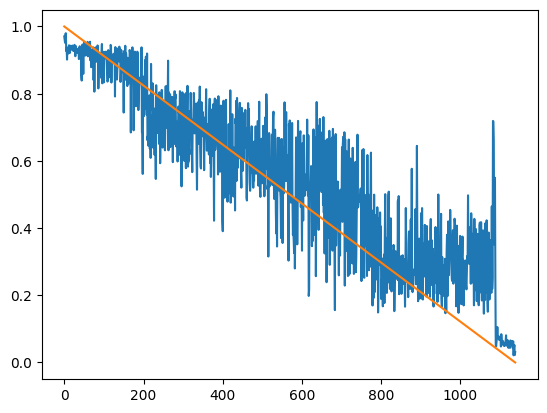

In [256]:
plt.plot(y_pred)
plt.plot(y_test)